In [2]:
import keras


Using TensorFlow backend.


In [3]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 949140551383463604
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1407909888
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16367607681082336717
physical_device_desc: "device: 0, name: GeForce 930MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [5]:
import numpy as np
import pandas as pd
from collections import defaultdict
import re

from bs4 import BeautifulSoup

import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Merge, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [9]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()


In [16]:
data_train = pd.read_csv('data/train_Mixed.csv')
data_train.text[1]

'Ever get the feeling your life circles the roundabout rather than heads in a straight line toward the intended destination? [Hillary Clinton remains the big woman on campus in leafy, liberal Wellesley, Massachusetts. Everywhere else votes her most likely to don her inauguration dress for the remainder of her days the way Miss Havisham forever wore that wedding dress.  Speaking of Great Expectations, Hillary Rodham overflowed with them 48 years ago when she first addressed a Wellesley graduating class. The president of the college informed those gathered in 1969 that the students needed “no debate so far as I could ascertain as to who their spokesman was to be” (kind of the like the Democratic primaries in 2016 minus the   terms unknown then even at a Seven Sisters school). “I am very glad that Miss Adams made it clear that what I am speaking for today is all of us —  the 400 of us,” Miss Rodham told her classmates. After appointing herself Edger Bergen to the Charlie McCarthys and Mor

In [18]:
# Input Data preprocessing
data_train = pd.read_csv('data/train_Mixed.csv')
#data_train['label'] = data_train['label'].replace('FAKE',1)
#data_train['label'] = data_train['label'].replace('REAL',0)
print(data_train.columns)
print('What the raw input data looks like:')
print(data_train[0:5])
texts = []
labels = []

for idx in range(data_train.text.shape[0]):
    text1 = data_train.title[idx]
    text2 = data_train.text[idx]
    text = str(text1) +""+ str(text2)
    #text = BeautifulSoup(data_train.title[idx] + " " + data_train.text[idx])
    #texts.append(clean_str(text.get_text()))
    texts.append(text)
    labels.append(data_train.label[idx])
    
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Index(['id', 'title', 'author', 'text', 'label'], dtype='object')
What the raw input data looks like:
   id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1  


/home/vin/anaconda3/lib/python3.6/site-packages/keras/preprocessing/text.py:172: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 251876 unique tokens.


In [19]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (20800, 1000)
Shape of label tensor: (20800, 2)


In [20]:
# Divide input into train,validation and test set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]
x_test = data[int(len(x_val)/2):len(x_val)]
y_test = labels[int(len(y_val)/2):len(y_val)]
x_val = x_val[:int(len(x_val)/2)]
y_val = y_val[:int(len(y_val)/2)]

print('Size of train, validation, and test sets:', len(y_train), len(y_val), len(y_test))

print('Number of real and fake news in training,validation and test sets:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, and test sets: 16640 2080 2080
Number of real and fake news in training,validation and test sets:
[8310. 8330.]
[1053. 1027.]
[1011. 1069.]


In [21]:
# Pre-trained word embeddings
GLOVE_DIR = "glove" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

FileNotFoundError: [Errno 2] No such file or directory: 'glove/glove.6B.100d.txt'

In [24]:
# Simple CNN model
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Fitting the simple convolutional neural network model")
model.summary()
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=10, batch_size=128)

ValueError: Input 0 is incompatible with layer conv1d_2: expected ndim=3, found ndim=2

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


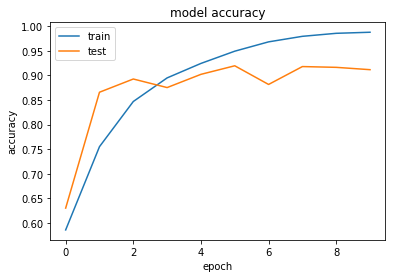

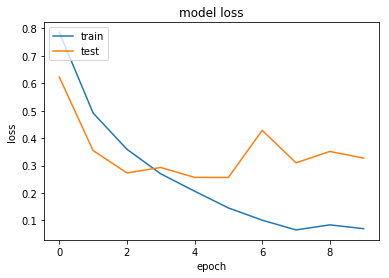

In [10]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
# Applying a more complex convolutional approach
convs = []
filter_sizes = [3,4,5]

sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

for fsz in filter_sizes:
    l_conv = Conv1D(nb_filter=128,filter_length=fsz,activation='relu')(embedded_sequences)
    l_pool = MaxPooling1D(5)(l_conv)
    convs.append(l_pool)
    
l_merge = Merge(mode='concat', concat_axis=1)(convs)
l_cov1= Conv1D(128, 5, activation='relu')(l_merge)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(30)(l_cov2)
l_flat = Flatten()(l_pool2)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(2, activation='softmax')(l_dense)

model2 = Model(sequence_input, preds)
model2.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Fitting a more complex convolutional neural network model")
model2.summary()
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val),
          nb_epoch=20, batch_size=50)

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=3)`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=4)`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=128, kernel_size=5)`
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:13: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  del sys.path[0]


Model fitting - complex convolutional neural network
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    9757900     input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 998, 128)     38528       embedding_1[2][0]                
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 997, 128)     51328       embedding_1[2][0]                
________________________________________________________

C:\ProgramData\Anaconda3\envs\deeplearning\lib\site-packages\ipykernel_launcher.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 5068 samples, validate on 633 samples
Epoch 1/20
5068/5068 [==============================] - 5s 1ms/step - loss: 0.5101 - acc: 0.7624 - val_loss: 0.2143 - val_acc: 0.9179
Epoch 2/20
5068/5068 [==============================] - 5s 929us/step - loss: 0.1429 - acc: 0.9499 - val_loss: 0.1803 - val_acc: 0.9368
Epoch 3/20
5068/5068 [==============================] - 5s 919us/step - loss: 0.0678 - acc: 0.9791 - val_loss: 0.2118 - val_acc: 0.9336
Epoch 4/20
5068/5068 [==============================] - 5s 921us/step - loss: 0.0335 - acc: 0.9903 - val_loss: 0.2683 - val_acc: 0.9336
Epoch 5/20
5068/5068 [==============================] - 5s 919us/step - loss: 0.0143 - acc: 0.9961 - val_loss: 0.2654 - val_acc: 0.9463
Epoch 6/20
5068/5068 [==============================] - 5s 918us/step - loss: 0.0131 - acc: 0.9959 - val_loss: 0.3296 - val_acc: 0.9415
Epoch 7/20
5068/5068 [==============================] - 5s 926us/step - loss: 7.1750e-05 - acc: 1.0000 - val_loss: 0.4332 - val_acc: 0.9415

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


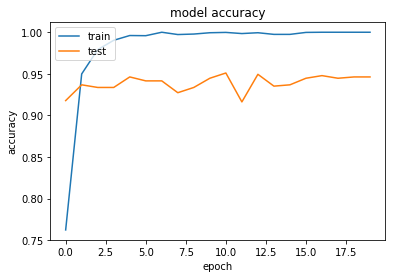

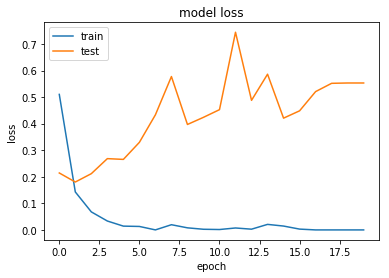

In [13]:
# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Correct predictions: 621.0
Total number of test examples: 634
Accuracy of model1:  0.9794952681388013
Correct predictions: 628.0
Total number of test examples: 634
Accuracy of model2:  0.9905362776025236


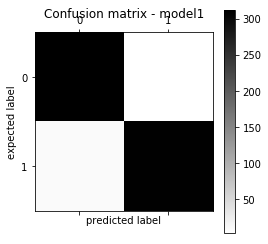

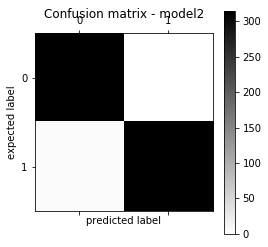

In [25]:
# Test model 1
test_preds = model.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = model.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model1')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
# plt.show()

#Test model 2
test_preds2 = model2.predict(x_test)
test_preds2 = np.round(test_preds2)
correct_predictions = float(sum(test_preds2 == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model2: ", correct_predictions/float(len(y_test)))

# Creating the Confusion Matrix
x_pred = model2.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
plt.matshow(cm, cmap=plt.cm.binary, interpolation='nearest')
plt.title('Confusion matrix - model2')
plt.colorbar()
plt.ylabel('expected label')
plt.xlabel('predicted label')
plt.show()

In [22]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.0691445213728
Test accuracy: 0.979495269455


In [23]:
score = model2.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.103605356085
Test accuracy: 0.990536277603
